## Plot model performance

Visualize performance on different models on data`2023-09-05` from the wandb API.

In [1]:
import pathlib
import itertools
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import wilcoxon
import seaborn as sns
import wandb

from utils import BodeColorPalette, get_runs_as_list
from src.util.definitions import DATA_ROOT
bode_palette = BodeColorPalette()

In [2]:
# settings
sns.set_theme(context="paper", 
              style="white", 
              font_scale=1, #0.7,
              rc={"savefig.transparent": True, 
                  "axes.grid": False, 
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,
                  "font.family":'sans-serif',
                  "font.sans-serif":["Helvetica", "Arial"],
                  "xtick.major.pad": 0.0,
                  "xtick.minor.pad": 0.0,
                  "ytick.major.pad": 0.0,
                  "ytick.minor.pad": 0.0,
                  "axes.labelweight": "bold",
                  "axes.labelpad": 2.5,  # standard is 4.0
                  "axes.xmargin": .05,
                 }, 
             )

# more settings for all plots
errorbar = "se"  # standard error of the mean
errwidth = .9
errcolor = "black"
capsize = .1  # size of the end of the errorbar
linewidth = 1.  # width of the outline of barplot

palette = [
    bode_palette.blues[0], 
    bode_palette.oranges[0],
    bode_palette.blues[2],
    bode_palette.oranges[2],
    bode_palette.blues[3],
    bode_palette.oranges[3]
]


### Get data from wandb API

In [3]:
summary_list, config_list, tag_list, name_list  = get_runs_as_list(filters={"$or":
                                                             [{"jobType": "training"},
                                                              {"jobType": "hparam_best"}
                                                             ]})
df_all = pd.json_normalize(config_list).merge(pd.json_normalize(summary_list), left_index=True, right_index=True)
df_all["tags"] = tag_list
df_all["run_id"] = name_list
df_all["run_group"] = [s.rsplit("_", maxsplit=1)[0] for s in name_list]
df_all["Model+Features"] = df_all["name"] + "/" + df_all["decoder.global_features"].str.join("+").str.replace("None", "CGR")
df_all["fold"] = df_all["run_id"].str[-1].astype(int)

In [4]:
# check available experiments by split
for tag, row in df_all.groupby("tags")[["experiment_id"]].agg(set).iterrows():
    print(tag, "-->", row["experiment_id"])

('0D',) --> {nan, 'JG1131', 'JG1115', 'JG1135', 'JG1160', 'JG1116', 'JG1100', 'JG1106', 'JG1185', 'JG1117', 'JG1109', 'JG1128'}
('0D', 'production') --> {'JG1187'}
('0D_0.625',) --> {'JG1267', 'JG1308', 'JG1265', 'JG1264', 'JG1266'}
('0D_1.25',) --> {'JG1147', 'JG1307', 'JG1141', 'JG1153', 'JG1159'}
('0D_10',) --> {'JG1150', 'JG1138', 'JG1304', 'JG1156', 'JG1144'}
('0D_2.5',) --> {'JG1158', 'JG1140', 'JG1152', 'JG1306', 'JG1146'}
('0D_20',) --> {'JG1143', 'JG1149', 'JG1137', 'JG1155', 'JG1303'}
('0D_40',) --> {'JG1136', 'JG1154', 'JG1148', 'JG1302', 'JG1142'}
('0D_5',) --> {'JG1145', 'JG1151', 'JG1305', 'JG1157', 'JG1139'}
('1D',) --> {'JG1126', 'JG1125', 'JG1123', 'JG1186', 'JG1104', 'JG1101', 'JG1132', 'JG1121', 'JG1129', 'JG1118', nan}
('1D_10',) --> {'JG1299', 'JG1170', 'JG1164', 'JG1176', 'JG1182'}
('1D_2.5',) --> {'JG1166', 'JG1172', 'JG1301', 'JG1178', 'JG1184'}
('1D_20',) --> {'JG1175', 'JG1298', 'JG1163', 'JG1181', 'JG1169'}
('1D_40',) --> {'JG1180', 'JG1162', 'JG1168', 'JG129

In [5]:
# set dir where we will save plots
analysis_dir = pathlib.Path("results")

## 0D split

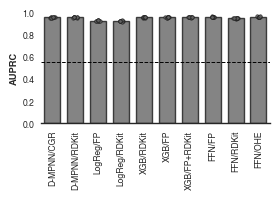

In [100]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D"
# choose the colorscheme
fill_color = '0.4'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
experiment_ids = [
    "JG1100",
    "JG1160",
    #"JG1135",  # GCN is very low compared to others
    "JG1185",
    "JG1106",
    "JG1109",
    "JG1128",
    "JG1131",
    "JG1115",
    "JG1116",
    "JG1117",
    
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.555, ls="--", color="black", linewidth=.7)  # chance level for val/0D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

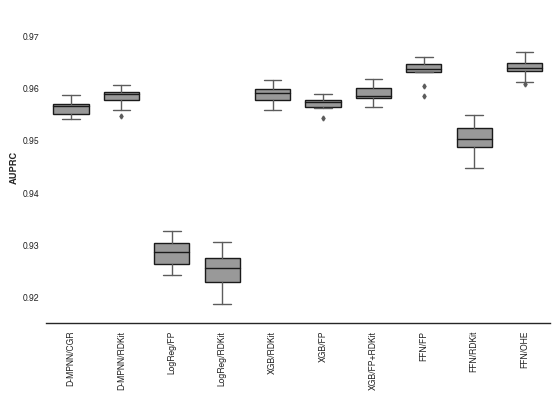

In [101]:
# try the same with a boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D"
# choose the colorscheme
fill_color = '0.6'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
experiment_ids = [
    "JG1100",
    "JG1160",
    #"JG1135",  # GCN is very low compared to others
    "JG1185",
    "JG1106",
    "JG1109",
    "JG1128",
    "JG1131",
    "JG1115",
    "JG1116",
    "JG1117",
    
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6,4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    color=fill_color,
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.set_ylabel("AUPRC")
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.915, 0.975))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_1807039/759668620.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


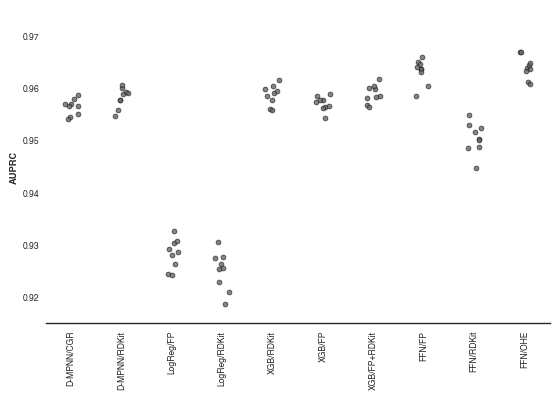

In [102]:
# try the same with a data points only
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D"
# choose the colorscheme
fill_color = '0.4'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
experiment_ids = [
    "JG1100",
    "JG1160",
    #"JG1135",  # GCN is very low compared to others
    "JG1185",
    "JG1106",
    "JG1109",
    "JG1128",
    "JG1131",
    "JG1115",
    "JG1116",
    "JG1117",
    
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6,4))

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
             )

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.915, 0.975))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

In [21]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
FFN/OHE,0.963872,0.002128
FFN/FP,0.963128,0.002338
XGB/FP+RDKit,0.958831,0.001758
XGB/RDKit,0.958611,0.001926
D-MPNN/RDKit,0.958101,0.001935
XGB/FP,0.956987,0.001382
D-MPNN/CGR,0.956286,0.001568
FFN/RDKit,0.950380,0.002953
LogisticRegression/FP,0.928250,0.002880


In [22]:
# is the best model significantly better than the rest?
best = "FFN/OHE"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

D-MPNN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
D-MPNN/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
LogisticRegression/FP :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/FP :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/FP+RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
FFN/FP :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)
FFN/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 1D split

In [23]:
df_plot["Model+Features"].value_counts()

Model+Features
D-MPNN/CGR                  9
D-MPNN/RDKit                9
LogisticRegression/FP       9
LogisticRegression/RDKit    9
XGB/RDKit                   9
XGB/FP                      9
XGB/FP+RDKit                9
FFN/FP                      9
FFN/RDKit                   9
FFN/OHE                     9
Name: count, dtype: int64

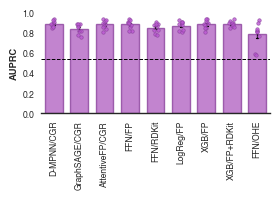

In [103]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1101",
    #"JG1104",  # GCN is very low compared to others
    "JG1121",
    "JG1123",
    "JG1125",
    "JG1126",
    "JG1186",
    "JG1129",
    "JG1132",
    "JG1118",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.537, ls="--", color="black", linewidth=.7)  # chance level for val/1D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

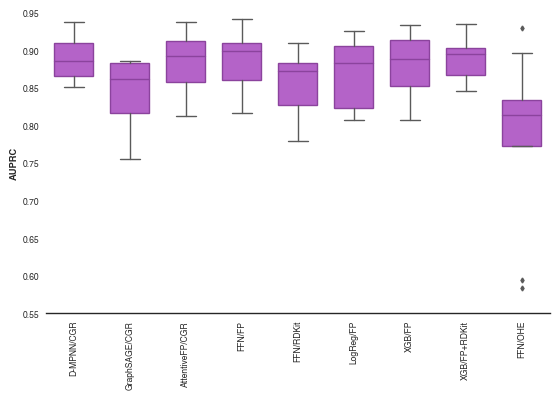

In [104]:
# make a boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1101",
    #"JG1104",  # GCN is very low compared to others
    "JG1121",
    "JG1123",
    "JG1125",
    "JG1126",
    "JG1186",
    "JG1129",
    "JG1132",
    "JG1118",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    color=fill_color,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.axhline(0.537, ls="--", color="black", linewidth=.7)  # chance level for val/1D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.55, 0.95))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_1807039/3605164932.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


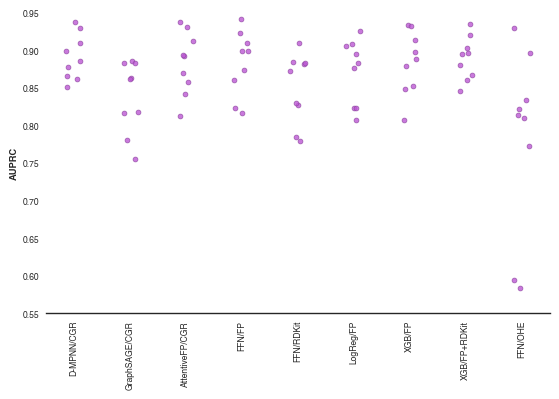

In [105]:
# make a boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1101",
    #"JG1104",  # GCN is very low compared to others
    "JG1121",
    "JG1123",
    "JG1125",
    "JG1126",
    "JG1186",
    "JG1129",
    "JG1132",
    "JG1118",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
             )

ax.axhline(0.537, ls="--", color="black", linewidth=.7)  # chance level for val/1D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.55, 0.95))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

In [25]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
D-MPNN/CGR,0.890784,0.030425
XGB/FP+RDKit,0.889293,0.028826
XGB/FP,0.883578,0.042024
FFN/FP,0.883107,0.043262
AttentiveFP/CGR,0.882898,0.041379
LogisticRegression/FP,0.871912,0.043093
FFN/RDKit,0.850365,0.046617
GraphSAGE/CGR,0.838695,0.048111
FFN/OHE,0.784098,0.120060


In [26]:
# is the best model significantly better than the rest?
best = "D-MPNN/CGR"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

GCN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=2.0, pvalue=0.01171875)
AttentiveFP/CGR :	 WilcoxonResult(statistic=14.0, pvalue=0.359375)
FFN/FP :	 WilcoxonResult(statistic=16.0, pvalue=0.49609375)
FFN/RDKit :	 WilcoxonResult(statistic=4.0, pvalue=0.02734375)
LogisticRegression/FP :	 WilcoxonResult(statistic=7.0, pvalue=0.07421875)
XGB/FP :	 WilcoxonResult(statistic=17.0, pvalue=0.5703125)
XGB/FP+RDKit :	 WilcoxonResult(statistic=20.0, pvalue=0.8203125)
FFN/OHE :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)


## 2D split

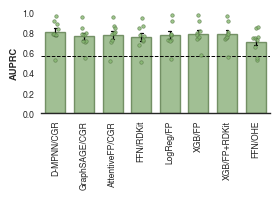

In [106]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1102",
    #"JG1105",  # GCN is very low compared to others
    "JG1122",
    "JG1124",
    "JG1127",
    "JG1112",
    "JG1130",
    "JG1133",
    "JG1119",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.569, ls="--", color="black", linewidth=.7)  # chance level for val/2D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

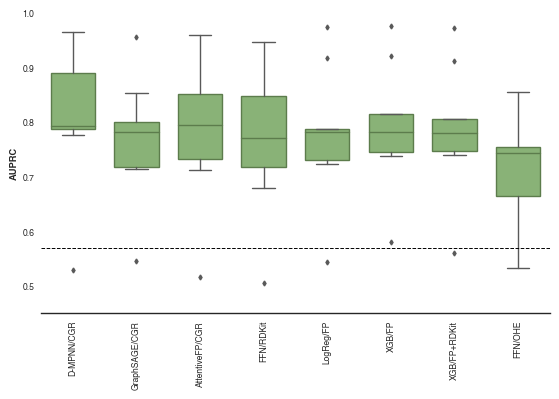

In [107]:
# make boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1102",
    #"JG1105",  # GCN is very low compared to others
    "JG1122",
    "JG1124",
    "JG1127",
    "JG1112",
    "JG1130",
    "JG1133",
    "JG1119",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    color=fill_color,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.axhline(0.569, ls="--", color="black", linewidth=.7)  # chance level for val/2D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.45, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_1807039/84798051.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


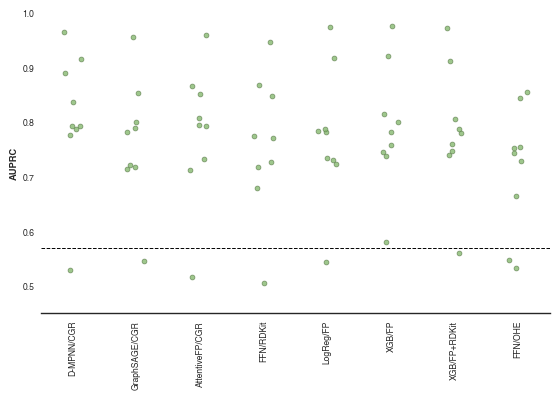

In [108]:
# make boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1102",
    #"JG1105",  # GCN is very low compared to others
    "JG1122",
    "JG1124",
    "JG1127",
    "JG1112",
    "JG1130",
    "JG1133",
    "JG1119",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
             )

ax.axhline(0.569, ls="--", color="black", linewidth=.7)  # chance level for val/2D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.45, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

In [28]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
D-MPNN/CGR,0.809626,0.124337
XGB/FP,0.790416,0.112848
XGB/FP+RDKit,0.784771,0.115233
AttentiveFP/CGR,0.781057,0.123634
LogisticRegression/FP,0.774621,0.122331
GraphSAGE/CGR,0.764278,0.112075
FFN/RDKit,0.759928,0.126657
FFN/OHE,0.713682,0.114297
GCN/CGR,0.655483,0.094320


In [30]:
# is the best model significantly better than the rest?
best = "D-MPNN/CGR"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

GCN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)
AttentiveFP/CGR :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)
FFN/RDKit :	 WilcoxonResult(statistic=1.0, pvalue=0.0078125)
LogisticRegression/FP :	 WilcoxonResult(statistic=7.0, pvalue=0.07421875)
XGB/FP :	 WilcoxonResult(statistic=12.0, pvalue=0.25)
XGB/FP+RDKit :	 WilcoxonResult(statistic=10.0, pvalue=0.1640625)
FFN/OHE :	 WilcoxonResult(statistic=1.0, pvalue=0.0078125)


## 3D split

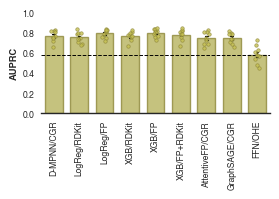

In [109]:
# barplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1103",
    "JG1107",
    "JG1108",
    "JG1110",
    "JG1111",
    "JG1134",
    "JG1113",
    "JG1114",
    "JG1120",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(0.578, ls="--", color="black", linewidth=.7)  # chance level for val/3D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

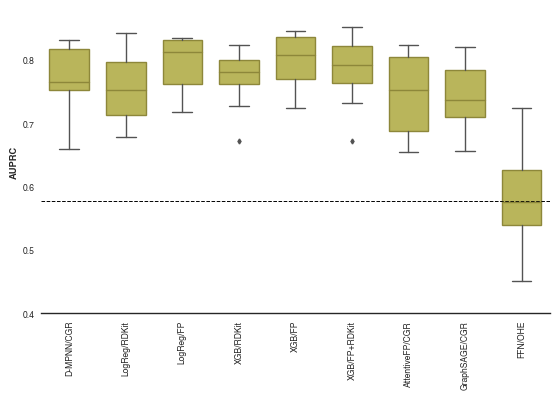

In [110]:
# boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1103",
    "JG1107",
    "JG1108",
    "JG1110",
    "JG1111",
    "JG1134",
    "JG1113",
    "JG1114",
    "JG1120",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    color=fill_color,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.axhline(0.578, ls="--", color="black", linewidth=.7)  # chance level for val/3D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.88))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_1807039/3301399306.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


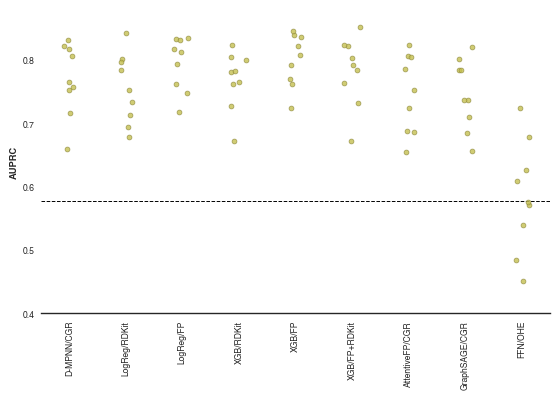

In [111]:
# scatter
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1103",
    "JG1107",
    "JG1108",
    "JG1110",
    "JG1111",
    "JG1134",
    "JG1113",
    "JG1114",
    "JG1120",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
)

ax.axhline(0.578, ls="--", color="black", linewidth=.7)  # chance level for val/3D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.88))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

/tmp/ipykernel_1698748/2599066874.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


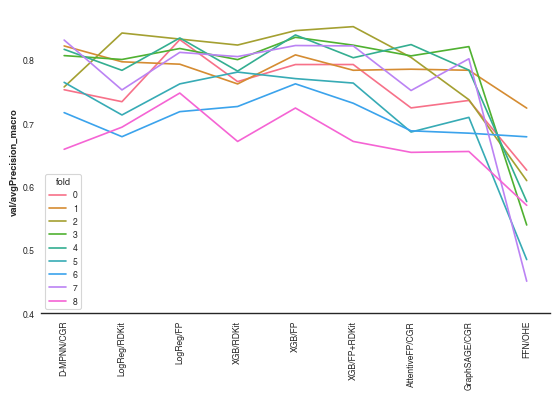

In [87]:
# try a lineplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1103",
    "JG1107",
    "JG1108",
    "JG1110",
    "JG1111",
    "JG1134",
    "JG1113",
    "JG1114",
    "JG1120",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.lineplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              hue="fold", 
              palette=sns.color_palette("husl", 9),
              #edgecolor=stroke_color,
              #color=fill_color,
              #linewidth=.5,
              #legend=False,
              #marker="o",
              #size=3.5,
              #alpha=.8
)

ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.88))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_line.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_line.png", dpi=300)

/tmp/ipykernel_1698748/3631786521.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


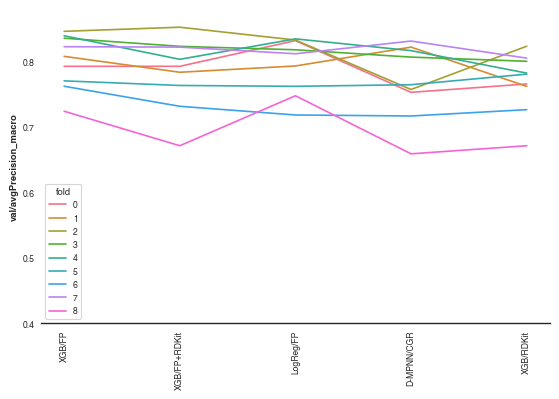

In [91]:
# same, but only best models
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
        "JG1111",
    "JG1134",
        "JG1108",
    "JG1103",


            "JG1110",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.lineplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              hue="fold", 
              palette=sns.color_palette("husl", 9),
              #edgecolor=stroke_color,
              #color=fill_color,
              #linewidth=.5,
              #legend=False,
              #marker="o",
              #size=3.5,
              #alpha=.8
)

ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.88))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_line.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}_line.png", dpi=300)

In [32]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
XGB/FP,0.800110,0.041297
LogisticRegression/FP,0.794498,0.042385
XGB/FP+RDKit,0.782625,0.054720
D-MPNN/CGR,0.769681,0.056595
XGB/RDKit,0.768620,0.046068
LogisticRegression/RDKit,0.755103,0.054808
AttentiveFP/CGR,0.747098,0.061750
GraphSAGE/CGR,0.745838,0.055996
FFN/OHE,0.584521,0.087108


In [33]:
# is the best model significantly better than the rest?
best = "XGB/FP"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

D-MPNN/CGR :	 WilcoxonResult(statistic=5.0, pvalue=0.0390625)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
LogisticRegression/FP :	 WilcoxonResult(statistic=15.0, pvalue=0.42578125)
XGB/RDKit :	 WilcoxonResult(statistic=1.0, pvalue=0.0078125)
XGB/FP+RDKit :	 WilcoxonResult(statistic=4.0, pvalue=0.02734375)
AttentiveFP/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
FFN/OHE :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 0D restricted data splits

In [6]:
palette = sns.color_palette(["#5790fc", "#f89c20", "#964a8b", "#e42536"])  # works for colorblind
palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294)]

In [7]:
# some settings for all following plots

# order used for hue/style
order = ['FFN/OHE', 'XGB/FP', 'XGB/FP+RDKit', 'D-MPNN/CGR', 'D-MPNN/RDKit']

# linestyle
dashes=[(3, 3), (3, 3), (1, 1), (3, 3), (1, 1)]

# alternative palette where two colors are reused with less saturation to show derivative categories
palette = sns.color_palette(["#5790fc", "#f89c20", "#a66611", "#a0228d", "#783b6e"])  # works for colorblind
palette = sns.color_palette(["#5790fc", "#f89c20", "#a66611", "#e42536", "#a1212c"])  # works for colorblind
palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.6509803921568628, 0.4, 0.06666666666666667),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.6313725490196078, 0.12941176470588237, 0.17254901960784313)]

In [9]:
def get_chance_ap(split_name, fold=None, set_type="test"):
    df = pd.read_csv(DATA_ROOT / "splits" / "split_statistics.csv")
    if fold is not None:
        return df.loc[(df["split_name"] == split_name ) & (df["fold"] == fold), f"Chance level average precision macro on {set_type} set"].item()
    else:
        return df.loc[(df["split_name"] == split_name ), f"Chance level average precision macro on {set_type} set"].mean()

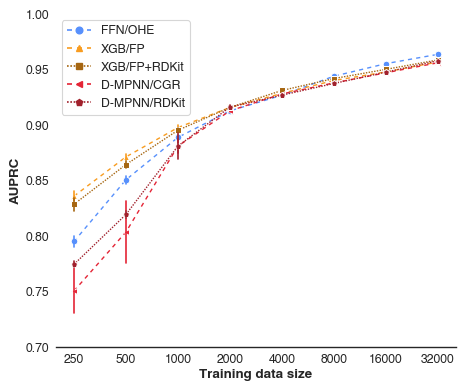

In [337]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _0.625
            "JG1266",  # D-MPNN+CGR
            "JG1265",  # XGB+FP+RDKit
            "JG1264",  # FFN+OHE
            "JG1267",  # D-MPNN+CGR+RDKit 
            "JG1308",  # XGB/FP
    ],
        [  # _1.25
            "JG1147",  # D-MPNN+CGR
            "JG1153",  # XGB+FP+RDKit
            "JG1141",  # FFN+OHE
            "JG1159",  # D-MPNN+CGR+RDKit
            "JG1307",  # XGB/FP
    ],
        [  # _2.5
            "JG1146",  # D-MPNN+CGR
            "JG1152",  # XGB+FP+RDKit
            "JG1140",  # FFN+OHE
            "JG1158",  # D-MPNN+CGR+RDKit
            "JG1306",  # XGB/FP
    ],
        [  # _5
            "JG1145",  # D-MPNN+CGR
            "JG1151",  # XGB+FP+RDKit
            "JG1139",  # FFN+OHE
            "JG1157",  # D-MPNN+CGR+RDKit
            "JG1305",  # XGB/FP
    ],
        [  # _10
            "JG1144",  # D-MPNN+CGR
            "JG1150",  # XGB+FP+RDKit
            "JG1138",  # FFN+OHE
            "JG1156",  # D-MPNN+CGR+RDKit
            "JG1304",  # XGB/FP
    ],
        [  # _20
            "JG1143",  # D-MPNN+CGR
            "JG1149",  # XGB+FP+RDKit
            "JG1137",  # FFN+OHE
            "JG1155",  # D-MPNN+CGR+RDKit
            "JG1303",  # XGB/FP
    ],
        [  # _40
            "JG1142",  # D-MPNN+CGR
            "JG1148",  # XGB+FP+RDKit
            "JG1136",  # FFN+OHE
            "JG1154",  # D-MPNN+CGR+RDKit
            "JG1302",  # XGB/FP
    ],
        [  # full
            "JG1100",  # D-MPNN+CGR
            "JG1131",  # XGB+FP+RDKit
            "JG1117",  # FFN+OHE
            "JG1160",  # D-MPNN+CGR+RDKit n/a for full 0D split
            "JG1128",  # XGB/FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "0D_0.625": 250,
    "0D_1.25": 500,
    "0D_2.5": 1000,
    "0D_5": 2000,
    "0D_10": 4001,
    "0D_20": 8003,
    "0D_40": 16006,
    "0D": 32014,
}

chance_level = [0.555, 0.555, 0.555, 0.555, 0.554, 0.555, 0.556, 0.555]  # same order as sample_counts

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)
# don't plot chance level b/c it is much lower
#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylim((0.7, 1))
ax.set_xticks(
    [250, 500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['250', '500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

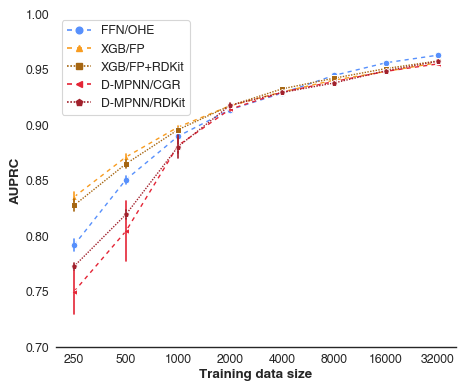

In [338]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _0.625
            "JG1266",  # D-MPNN+CGR
            "JG1265",  # XGB+FP+RDKit
            "JG1264",  # FFN+OHE
            "JG1267",  # D-MPNN+CGR+RDKit 
            "JG1308",  # XGB/FP
    ],
        [  # _1.25
            "JG1147",  # D-MPNN+CGR
            "JG1153",  # XGB+FP+RDKit
            "JG1141",  # FFN+OHE
            "JG1159",  # D-MPNN+CGR+RDKit
            "JG1307",  # XGB/FP
    ],
        [  # _2.5
            "JG1146",  # D-MPNN+CGR
            "JG1152",  # XGB+FP+RDKit
            "JG1140",  # FFN+OHE
            "JG1158",  # D-MPNN+CGR+RDKit
            "JG1306",  # XGB/FP
    ],
        [  # _5
            "JG1145",  # D-MPNN+CGR
            "JG1151",  # XGB+FP+RDKit
            "JG1139",  # FFN+OHE
            "JG1157",  # D-MPNN+CGR+RDKit
            "JG1305",  # XGB/FP
    ],
        [  # _10
            "JG1144",  # D-MPNN+CGR
            "JG1150",  # XGB+FP+RDKit
            "JG1138",  # FFN+OHE
            "JG1156",  # D-MPNN+CGR+RDKit
            "JG1304",  # XGB/FP
    ],
        [  # _20
            "JG1143",  # D-MPNN+CGR
            "JG1149",  # XGB+FP+RDKit
            "JG1137",  # FFN+OHE
            "JG1155",  # D-MPNN+CGR+RDKit
            "JG1303",  # XGB/FP
    ],
        [  # _40
            "JG1142",  # D-MPNN+CGR
            "JG1148",  # XGB+FP+RDKit
            "JG1136",  # FFN+OHE
            "JG1154",  # D-MPNN+CGR+RDKit
            "JG1302",  # XGB/FP
    ],
        [  # full
            "JG1100",  # D-MPNN+CGR
            "JG1131",  # XGB+FP+RDKit
            "JG1117",  # FFN+OHE
            "JG1160",  # D-MPNN+CGR+RDKit n/a for full 0D split
            "JG1128",  # XGB/FP
    ],
]
sample_counts = {  # mean number of training samples for each split
    "0D_0.625": 250,
    "0D_1.25": 500,
    "0D_2.5": 1000,
    "0D_5": 2000,
    "0D_10": 4001,
    "0D_20": 8003,
    "0D_40": 16006,
    "0D": 32014,
}

chance_level = [0.555, 0.556, 0.556, 0.556, 0.556, 0.556, 0.555, 0.555]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

# don't plot chance level b/c it is much lower
#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylim((0.7, 1))
ax.set_xticks(
    [250, 500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['250', '500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

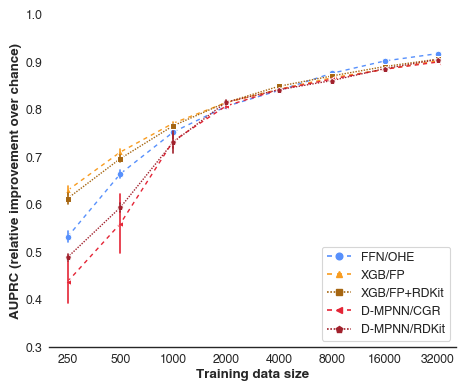

In [32]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"


# choose the data to plot
experiment_ids = [
        [  # _0.625
            "JG1266",  # D-MPNN+CGR
            "JG1265",  # XGB+FP+RDKit
            "JG1264",  # FFN+OHE
            "JG1267",  # D-MPNN+CGR+RDKit 
            "JG1308",  # XGB/FP
    ],
        [  # _1.25
            "JG1147",  # D-MPNN+CGR
            "JG1153",  # XGB+FP+RDKit
            "JG1141",  # FFN+OHE
            "JG1159",  # D-MPNN+CGR+RDKit
            "JG1307",  # XGB/FP
    ],
        [  # _2.5
            "JG1146",  # D-MPNN+CGR
            "JG1152",  # XGB+FP+RDKit
            "JG1140",  # FFN+OHE
            "JG1158",  # D-MPNN+CGR+RDKit
            "JG1306",  # XGB/FP
    ],
        [  # _5
            "JG1145",  # D-MPNN+CGR
            "JG1151",  # XGB+FP+RDKit
            "JG1139",  # FFN+OHE
            "JG1157",  # D-MPNN+CGR+RDKit
            "JG1305",  # XGB/FP
    ],
        [  # _10
            "JG1144",  # D-MPNN+CGR
            "JG1150",  # XGB+FP+RDKit
            "JG1138",  # FFN+OHE
            "JG1156",  # D-MPNN+CGR+RDKit
            "JG1304",  # XGB/FP
    ],
        [  # _20
            "JG1143",  # D-MPNN+CGR
            "JG1149",  # XGB+FP+RDKit
            "JG1137",  # FFN+OHE
            "JG1155",  # D-MPNN+CGR+RDKit
            "JG1303",  # XGB/FP
    ],
        [  # _40
            "JG1142",  # D-MPNN+CGR
            "JG1148",  # XGB+FP+RDKit
            "JG1136",  # FFN+OHE
            "JG1154",  # D-MPNN+CGR+RDKit
            "JG1302",  # XGB/FP
    ],
        [  # full
            "JG1100",  # D-MPNN+CGR
            "JG1131",  # XGB+FP+RDKit
            "JG1117",  # FFN+OHE
            "JG1160",  # D-MPNN+CGR+RDKit n/a for full 0D split
            "JG1128",  # XGB/FP
    ],
]
sample_counts = {  # mean number of training samples for each split
    "0D_0.625": 250,
    "0D_1.25": 500,
    "0D_2.5": 1000,
    "0D_5": 2000,
    "0D_10": 4001,
    "0D_20": 8003,
    "0D_40": 16006,
    "0D": 32014,
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
chance_dict = {k: v for k, v in zip(sample_counts.keys(), chance_level)}
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.3, 1))
ax.set_xticks(
    [250, 500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['250', '500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="lower right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_0D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)

## 1D restricted data splits

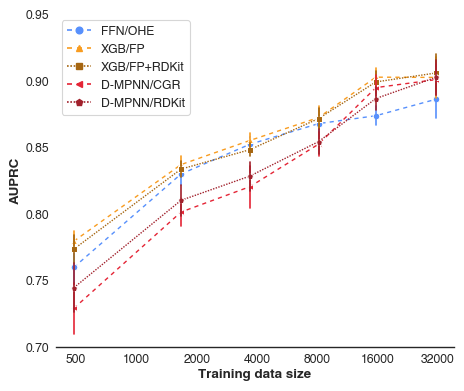

In [339]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
tags = ["1D_2.5", "1D_5", "1D_10", "1D_20", "1D_40", "1D_80"]

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1178",  # D-MPNN+CGR
            "JG1172",  # XGB+FP+RDKit
            "JG1166",  # FFN+OHE
            "JG1184",  # D-MPNN+CGR+RDKit
            "JG1301",  # XGB+FP
    ],
        [  # _5
            "JG1177",  # D-MPNN+CGR
            "JG1171",  # XGB+FP+RDKit
            "JG1165",  # FFN+OHE
            "JG1183",  # D-MPNN+CGR+RDKit
            "JG1300",  # XGB+FP
    ],
        [  # _10
            "JG1176",  # D-MPNN+CGR
            "JG1170",  # XGB+FP+RDKit
            "JG1164",  # FFN+OHE
            "JG1182",  # D-MPNN+CGR+RDKit
            "JG1299",  # XGB+FP
    ],
        [  # _20
            "JG1175",  # D-MPNN+CGR
            "JG1169",  # XGB+FP+RDKit
            "JG1163",  # FFN+OHE
            "JG1181",  # D-MPNN+CGR+RDKit
            "JG1298",  # XGB+FP
    ],
        [  # _40
            "JG1174",  # D-MPNN+CGR
            "JG1168",  # XGB+FP+RDKit
            "JG1162",  # FFN+OHE
            "JG1180",  # D-MPNN+CGR+RDKit
            "JG1297",  # XGB+FP
    ],
        [  # _80
            "JG1173",  # D-MPNN+CGR
            "JG1167",  # XGB+FP+RDKit
            "JG1161",  # FFN+OHE
            "JG1179",  # D-MPNN+CGR+RDKit
            "JG1296",  # XGB+FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "1D_2.5": 487,
    "1D_5": 1668,
    "1D_10": 3680,
    "1D_20": 8107,
    "1D_40": 15648,
    "1D_80": 31250,
}

chance_level = [0.562, 0.565, 0.581, 0.551, 0.578, 0.570]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.70, 0.95))
ax.set_xticks(
    [500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

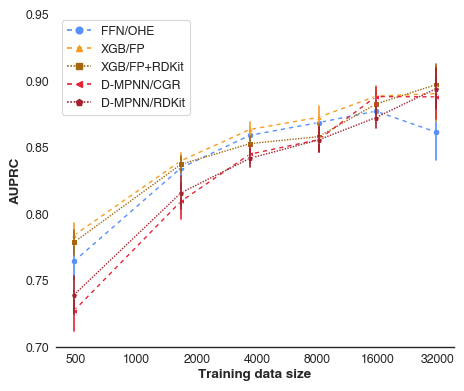

In [404]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1178",  # D-MPNN+CGR
            "JG1172",  # XGB+FP+RDKit
            "JG1166",  # FFN+OHE
            "JG1184",  # D-MPNN+CGR+RDKit
            "JG1301",  # XGB+FP
    ],
        [  # _5
            "JG1177",  # D-MPNN+CGR
            "JG1171",  # XGB+FP+RDKit
            "JG1165",  # FFN+OHE
            "JG1183",  # D-MPNN+CGR+RDKit
            "JG1300",  # XGB+FP
    ],
        [  # _10
            "JG1176",  # D-MPNN+CGR
            "JG1170",  # XGB+FP+RDKit
            "JG1164",  # FFN+OHE
            "JG1182",  # D-MPNN+CGR+RDKit
            "JG1299",  # XGB+FP
    ],
        [  # _20
            "JG1175",  # D-MPNN+CGR
            "JG1169",  # XGB+FP+RDKit
            "JG1163",  # FFN+OHE
            "JG1181",  # D-MPNN+CGR+RDKit
            "JG1298",  # XGB+FP
    ],
        [  # _40
            "JG1174",  # D-MPNN+CGR
            "JG1168",  # XGB+FP+RDKit
            "JG1162",  # FFN+OHE
            "JG1180",  # D-MPNN+CGR+RDKit
            "JG1297",  # XGB+FP
    ],
        [  # _80
            "JG1173",  # D-MPNN+CGR
            "JG1167",  # XGB+FP+RDKit
            "JG1161",  # FFN+OHE
            "JG1179",  # D-MPNN+CGR+RDKit
            "JG1296",  # XGB+FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "1D_2.5": 487,
    "1D_5": 1668,
    "1D_10": 3680,
    "1D_20": 8107,
    "1D_40": 15648,
    "1D_80": 31250,
}

chance_level = [0.562, 0.565, 0.581, 0.551, 0.578, 0.570]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.70, 0.95))
ax.set_xticks(
    [500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['500', '1000', '2000', '4000', '8000', '16000', '32000']
)

ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

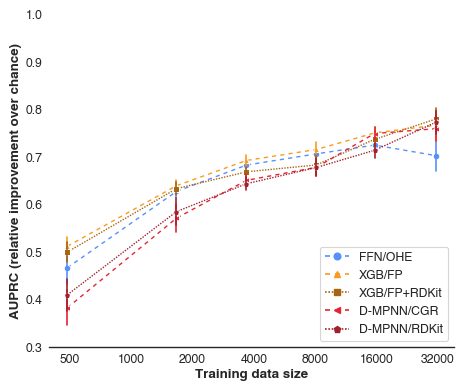

In [33]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1178",  # D-MPNN+CGR
            "JG1172",  # XGB+FP+RDKit
            "JG1166",  # FFN+OHE
            "JG1184",  # D-MPNN+CGR+RDKit
            "JG1301",  # XGB+FP
    ],
        [  # _5
            "JG1177",  # D-MPNN+CGR
            "JG1171",  # XGB+FP+RDKit
            "JG1165",  # FFN+OHE
            "JG1183",  # D-MPNN+CGR+RDKit
            "JG1300",  # XGB+FP
    ],
        [  # _10
            "JG1176",  # D-MPNN+CGR
            "JG1170",  # XGB+FP+RDKit
            "JG1164",  # FFN+OHE
            "JG1182",  # D-MPNN+CGR+RDKit
            "JG1299",  # XGB+FP
    ],
        [  # _20
            "JG1175",  # D-MPNN+CGR
            "JG1169",  # XGB+FP+RDKit
            "JG1163",  # FFN+OHE
            "JG1181",  # D-MPNN+CGR+RDKit
            "JG1298",  # XGB+FP
    ],
        [  # _40
            "JG1174",  # D-MPNN+CGR
            "JG1168",  # XGB+FP+RDKit
            "JG1162",  # FFN+OHE
            "JG1180",  # D-MPNN+CGR+RDKit
            "JG1297",  # XGB+FP
    ],
        [  # _80
            "JG1173",  # D-MPNN+CGR
            "JG1167",  # XGB+FP+RDKit
            "JG1161",  # FFN+OHE
            "JG1179",  # D-MPNN+CGR+RDKit
            "JG1296",  # XGB+FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "1D_2.5": 487,
    "1D_5": 1668,
    "1D_10": 3680,
    "1D_20": 8107,
    "1D_40": 15648,
    "1D_80": 31250,
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
chance_dict = {k: v for k, v in zip(sample_counts.keys(), chance_level)}
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.3, 1))
ax.set_xticks(
    [500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="lower right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_1D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)

## 2D restricted data splits

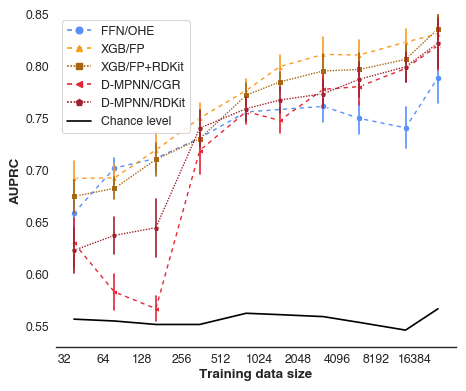

In [403]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"

# choose the data to plot
experiment_ids = [   
        [  # _2
            "JG1246",  # D-MPNN+CGR
            "JG1245",  # XGB+FP+RDKit
            "JG1244",  # FFN+OHE
            "JG1247",  # D-MPNN+CGR+RDKit
            "JG1295",  # XGB+FP
    ],
        [  # _5
            "JG1254",  # D-MPNN+CGR
            "JG1253",  # XGB+FP+RDKit
            "JG1252",  # FFN+OHE
            "JG1255",  # D-MPNN+CGR+RDKit
            "JG1294",  # XGB+FP
    ],
        [  # _7.5
            "JG1270",  # D-MPNN+CGR
            "JG1269",  # XGB+FP+RDKit
            "JG1268",  # FFN+OHE
            "JG1271",  # D-MPNN+CGR+RDKit
            "JG1293",  # XGB+FP
    ],
        [  # _10
            "JG1238",  # D-MPNN+CGR
            "JG1237",  # XGB+FP+RDKit
            "JG1236",  # FFN+OHE
            "JG1239",  # D-MPNN+CGR+RDKit
            "JG1292",  # XGB+FP
    ],
        [  # _15
            "JG1205",  # D-MPNN+CGR
            "JG1199",  # XGB+FP+RDKit
            "JG1193",  # FFN+OHE
            "JG1211",  # D-MPNN+CGR+RDKit
            "JG1291",  # XGB+FP
    ],
        [  # _20
            "JG1204",  # D-MPNN+CGR
            "JG1198",  # XGB+FP+RDKit
            "JG1192",  # FFN+OHE
            "JG1210",  # D-MPNN+CGR+RDKit
            "JG1290",  # XGB+FP
    ],
        [  # _30
            "JG1203",  # D-MPNN+CGR
            "JG1197",  # XGB+FP+RDKit
            "JG1191",  # FFN+OHE
            "JG1209",  # D-MPNN+CGR+RDKit
            "JG1289",  # XGB+FP
    ],
        [  # _40
            "JG1202",  # D-MPNN+CGR
            "JG1196",  # XGB+FP+RDKit
            "JG1190",  # FFN+OHE
            "JG1208",  # D-MPNN+CGR+RDKit
            "JG1288",  # XGB+FP
    ],
        [  # _60
            "JG1201",  # D-MPNN+CGR
            "JG1195",  # XGB+FP+RDKit
            "JG1189",  # FFN+OHE
            "JG1207",  # D-MPNN+CGR+RDKit
            "JG1287",  # XGB+FP
    ],
        # note: we do not use the results from _80 due to high variance (too small test set)
        [  # _80
            "JG1200",  # D-MPNN+CGR
            "JG1194",  # XGB+FP+RDKit
            "JG1188",  # FFN+OHE
            "JG1206",  # D-MPNN+CGR+RDKit
            "JG1286",  # XGB+FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "2D_2": 38,
    "2D_5": 78,
    "2D_7.5": 163,
    "2D_10": 355,
    "2D_15": 812,
    "2D_20": 1475,
    "2D_30": 3193,
    "2D_40": 6046,
    "2D_60": 13802,
    "2D_80": 24562,
}

chance_level = [get_chance_ap(split, set_type="val") for split in sample_counts.keys()]


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.53, 0.85))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)

ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_2D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_2D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

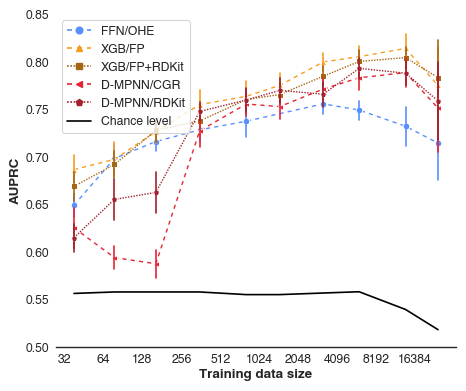

In [400]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [   
        [  # _2
            "JG1246",  # D-MPNN+CGR
            "JG1245",  # XGB+FP+RDKit
            "JG1244",  # FFN+OHE
            "JG1247",  # D-MPNN+CGR+RDKit
            "JG1295",  # XGB+FP
    ],
        [  # _5
            "JG1254",  # D-MPNN+CGR
            "JG1253",  # XGB+FP+RDKit
            "JG1252",  # FFN+OHE
            "JG1255",  # D-MPNN+CGR+RDKit
            "JG1294",  # XGB+FP
    ],
        [  # _7.5
            "JG1270",  # D-MPNN+CGR
            "JG1269",  # XGB+FP+RDKit
            "JG1268",  # FFN+OHE
            "JG1271",  # D-MPNN+CGR+RDKit
            "JG1293",  # XGB+FP
    ],
        [  # _10
            "JG1238",  # D-MPNN+CGR
            "JG1237",  # XGB+FP+RDKit
            "JG1236",  # FFN+OHE
            "JG1239",  # D-MPNN+CGR+RDKit
            "JG1292",  # XGB+FP
    ],
        [  # _15
            "JG1205",  # D-MPNN+CGR
            "JG1199",  # XGB+FP+RDKit
            "JG1193",  # FFN+OHE
            "JG1211",  # D-MPNN+CGR+RDKit
            "JG1291",  # XGB+FP
    ],
        [  # _20
            "JG1204",  # D-MPNN+CGR
            "JG1198",  # XGB+FP+RDKit
            "JG1192",  # FFN+OHE
            "JG1210",  # D-MPNN+CGR+RDKit
            "JG1290",  # XGB+FP
    ],
        [  # _30
            "JG1203",  # D-MPNN+CGR
            "JG1197",  # XGB+FP+RDKit
            "JG1191",  # FFN+OHE
            "JG1209",  # D-MPNN+CGR+RDKit
            "JG1289",  # XGB+FP
    ],
        [  # _40
            "JG1202",  # D-MPNN+CGR
            "JG1196",  # XGB+FP+RDKit
            "JG1190",  # FFN+OHE
            "JG1208",  # D-MPNN+CGR+RDKit
            "JG1288",  # XGB+FP
    ],
        [  # _60
            "JG1201",  # D-MPNN+CGR
            "JG1195",  # XGB+FP+RDKit
            "JG1189",  # FFN+OHE
            "JG1207",  # D-MPNN+CGR+RDKit
            "JG1287",  # XGB+FP
    ],
        # note: we do not use the results from _80 due to high variance (too small test set)
        [  # _80
            "JG1200",  # D-MPNN+CGR
            "JG1194",  # XGB+FP+RDKit
            "JG1188",  # FFN+OHE
            "JG1206",  # D-MPNN+CGR+RDKit
            "JG1286",  # XGB+FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "2D_2": 38,
    "2D_5": 78,
    "2D_7.5": 163,
    "2D_10": 355,
    "2D_15": 812,
    "2D_20": 1475,
    "2D_30": 3193,
    "2D_40": 6046,
    "2D_60": 13802,
    "2D_80": 24562,
}

chance_level = [get_chance_ap(split) for split in sample_counts.keys()]

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.85))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_2D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_2D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

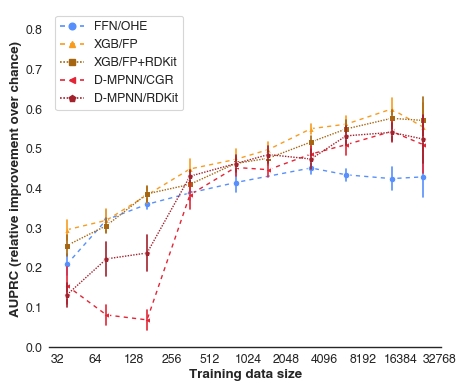

In [12]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [   
        [  # _2
            "JG1246",  # D-MPNN+CGR
            "JG1245",  # XGB+FP+RDKit
            "JG1244",  # FFN+OHE
            "JG1247",  # D-MPNN+CGR+RDKit
            "JG1295",  # XGB+FP
    ],
        [  # _5
            "JG1254",  # D-MPNN+CGR
            "JG1253",  # XGB+FP+RDKit
            "JG1252",  # FFN+OHE
            "JG1255",  # D-MPNN+CGR+RDKit
            "JG1294",  # XGB+FP
    ],
        [  # _7.5
            "JG1270",  # D-MPNN+CGR
            "JG1269",  # XGB+FP+RDKit
            "JG1268",  # FFN+OHE
            "JG1271",  # D-MPNN+CGR+RDKit
            "JG1293",  # XGB+FP
    ],
        [  # _10
            "JG1238",  # D-MPNN+CGR
            "JG1237",  # XGB+FP+RDKit
            "JG1236",  # FFN+OHE
            "JG1239",  # D-MPNN+CGR+RDKit
            "JG1292",  # XGB+FP
    ],
        [  # _15
            "JG1205",  # D-MPNN+CGR
            "JG1199",  # XGB+FP+RDKit
            "JG1193",  # FFN+OHE
            "JG1211",  # D-MPNN+CGR+RDKit
            "JG1291",  # XGB+FP
    ],
        [  # _20
            "JG1204",  # D-MPNN+CGR
            "JG1198",  # XGB+FP+RDKit
            "JG1192",  # FFN+OHE
            "JG1210",  # D-MPNN+CGR+RDKit
            "JG1290",  # XGB+FP
    ],
        [  # _30
            "JG1203",  # D-MPNN+CGR
            "JG1197",  # XGB+FP+RDKit
            "JG1191",  # FFN+OHE
            "JG1209",  # D-MPNN+CGR+RDKit
            "JG1289",  # XGB+FP
    ],
        [  # _40
            "JG1202",  # D-MPNN+CGR
            "JG1196",  # XGB+FP+RDKit
            "JG1190",  # FFN+OHE
            "JG1208",  # D-MPNN+CGR+RDKit
            "JG1288",  # XGB+FP
    ],
        [  # _60
            "JG1201",  # D-MPNN+CGR
            "JG1195",  # XGB+FP+RDKit
            "JG1189",  # FFN+OHE
            "JG1207",  # D-MPNN+CGR+RDKit
            "JG1287",  # XGB+FP
    ],
        # note: we do not use the results from _80 due to high variance (too small test set)
        [  # _80
            "JG1200",  # D-MPNN+CGR
            "JG1194",  # XGB+FP+RDKit
            "JG1188",  # FFN+OHE
            "JG1206",  # D-MPNN+CGR+RDKit
            "JG1286",  # XGB+FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "2D_2": 38,
    "2D_5": 78,
    "2D_7.5": 163,
    "2D_10": 355,
    "2D_15": 812,
    "2D_20": 1475,
    "2D_30": 3193,
    "2D_40": 6046,
    "2D_60": 13802,
    "2D_80": 24562,
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
chance_dict = {k: v for k, v in zip(sample_counts.keys(), chance_level)}
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0., 0.85))
ax.set_xticks(
    [32*2**n for n in range(11)], 
    [f"{32*2**n}" for n in range(11)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_2D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_2D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)

## 3D restricted data splits

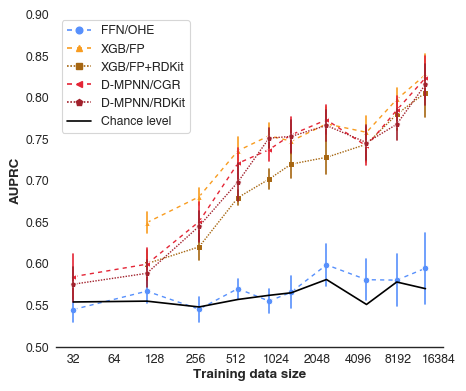

In [343]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _10
            "JG1242",  # D-MPNN+CGR
            "JG1241",  # XGB+FP+RDKit
            "JG1240",  # FFN+OHE
            "JG1243",  # D-MPNN+CGR+RDKit
            "JG1285",  # XGB/FP
    ],
        [  # _15
            "JG1274",  # D-MPNN+CGR
            "JG1273",  # XGB+FP+RDKit
            "JG1272",  # FFN+OHE
            "JG1275",  # D-MPNN+CGR+RDKit
            "JG1284",  # XGB/FP
            
    ],
        [  # _20
            "JG1250",  # D-MPNN+CGR
            "JG1249",  # XGB+FP+RDKit
            "JG1248",  # FFN+OHE
            "JG1251",  # D-MPNN+CGR+RDKit
            "JG1283",  # XGB/FP
    ],
        [  # _25
            "JG1262",  # D-MPNN+CGR
            "JG1261",  # XGB+FP+RDKit
            "JG1260",  # FFN+OHE
            "JG1263",  # D-MPNN+CGR+RDKit
            "JG1282",  # XGB/FP
    ],
        [  # _30
            "JG1229",  # D-MPNN+CGR
            "JG1223",  # XGB+FP+RDKit
            "JG1217",  # FFN+OHE
            "JG1235",  # D-MPNN+CGR+RDKit
            "JG1281",  # XGB/FP
    ],
        [  # _34
            "JG1228",  # D-MPNN+CGR
            "JG1222",  # XGB+FP+RDKit
            "JG1216",  # FFN+OHE
            "JG1234",  # D-MPNN+CGR+RDKit
            "JG1280",  # XGB/FP
    ],
        [  # _40
            "JG1227",  # D-MPNN+CGR
            "JG1221",  # XGB+FP+RDKit
            "JG1215",  # FFN+OHE
            "JG1233",  # D-MPNN+CGR+RDKit
            "JG1279",  # XGB/FP
    ],
        [  # _50
            "JG1226",  # D-MPNN+CGR
            "JG1220",  # XGB+FP+RDKit
            "JG1214",  # FFN+OHE
            "JG1232",  # D-MPNN+CGR+RDKit
            "JG1278",  # XGB/FP
    ],
        [  # _60
            "JG1225",  # D-MPNN+CGR
            "JG1219",  # XGB+FP+RDKit
            "JG1213",  # FFN+OHE
            "JG1231",  # D-MPNN+CGR+RDKit
            "JG1277",  # XGB/FP
    ],
        [  # _70
            "JG1224",  # D-MPNN+CGR
            "JG1218",  # XGB+FP+RDKit
            "JG1212",  # FFN+OHE
            "JG1230",  # D-MPNN+CGR+RDKit
            "JG1276",  # XGB/FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "3D_10": 32,
    "3D_15": 112,
    "3D_20": 273,
    "3D_25": 529,
    "3D_30": 901,
    "3D_34": 1313,
    "3D_40": 2399,
    "3D_50": 4747,
    "3D_60": 7948,
    "3D_70": 12975,
}

chance_level = [0.554, 0.555, 0.548, 0.557, 0.562, 0.565, 0.581, 0.551, 0.578, 0.570]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    style="Model+Features",
    hue="Model+Features",
    hue_order=order,
    style_order=order,
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.9))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)
ax.legend(loc="upper left", title=None)


fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

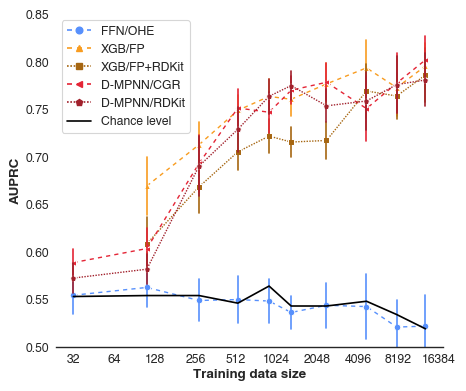

In [345]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _10
            "JG1242",  # D-MPNN+CGR
            "JG1241",  # XGB+FP+RDKit
            "JG1240",  # FFN+OHE
            "JG1243",  # D-MPNN+CGR+RDKit
            "JG1285",  # XGB/FP
    ],
        [  # _15
            "JG1274",  # D-MPNN+CGR
            "JG1273",  # XGB+FP+RDKit
            "JG1272",  # FFN+OHE
            "JG1275",  # D-MPNN+CGR+RDKit
            "JG1284",  # XGB/FP
            
    ],
        [  # _20
            "JG1250",  # D-MPNN+CGR
            "JG1249",  # XGB+FP+RDKit
            "JG1248",  # FFN+OHE
            "JG1251",  # D-MPNN+CGR+RDKit
            "JG1283",  # XGB/FP
    ],
        [  # _25
            "JG1262",  # D-MPNN+CGR
            "JG1261",  # XGB+FP+RDKit
            "JG1260",  # FFN+OHE
            "JG1263",  # D-MPNN+CGR+RDKit
            "JG1282",  # XGB/FP
    ],
        [  # _30
            "JG1229",  # D-MPNN+CGR
            "JG1223",  # XGB+FP+RDKit
            "JG1217",  # FFN+OHE
            "JG1235",  # D-MPNN+CGR+RDKit
            "JG1281",  # XGB/FP
    ],
        [  # _34
            "JG1228",  # D-MPNN+CGR
            "JG1222",  # XGB+FP+RDKit
            "JG1216",  # FFN+OHE
            "JG1234",  # D-MPNN+CGR+RDKit
            "JG1280",  # XGB/FP
    ],
        [  # _40
            "JG1227",  # D-MPNN+CGR
            "JG1221",  # XGB+FP+RDKit
            "JG1215",  # FFN+OHE
            "JG1233",  # D-MPNN+CGR+RDKit
            "JG1279",  # XGB/FP
    ],
        [  # _50
            "JG1226",  # D-MPNN+CGR
            "JG1220",  # XGB+FP+RDKit
            "JG1214",  # FFN+OHE
            "JG1232",  # D-MPNN+CGR+RDKit
            "JG1278",  # XGB/FP
    ],
        [  # _60
            "JG1225",  # D-MPNN+CGR
            "JG1219",  # XGB+FP+RDKit
            "JG1213",  # FFN+OHE
            "JG1231",  # D-MPNN+CGR+RDKit
            "JG1277",  # XGB/FP
    ],
        [  # _70
            "JG1224",  # D-MPNN+CGR
            "JG1218",  # XGB+FP+RDKit
            "JG1212",  # FFN+OHE
            "JG1230",  # D-MPNN+CGR+RDKit
            "JG1276",  # XGB/FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "3D_10": 32,
    "3D_15": 112,
    "3D_20": 273,
    "3D_25": 529,
    "3D_30": 901,
    "3D_34": 1313,
    "3D_40": 2399,
    "3D_50": 4747,
    "3D_60": 7948,
    "3D_70": 12975,
}

chance_level = [0.553, 0.554, 0.554, 0.546, 0.564, 0.543, 0.543, 0.548, 0.534, 0.519]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    dashes=dashes,
    errorbar=errorbar,
    err_style="bars",
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.85))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

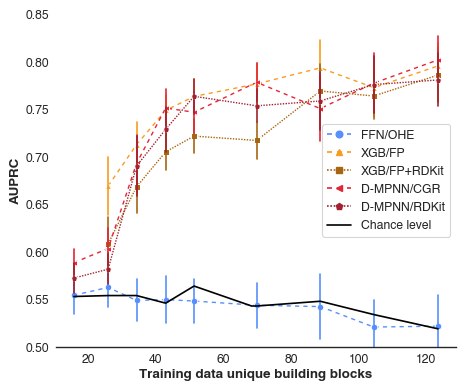

In [350]:
# repetition of the last plot, but with number of seen building blocks on the x axis instead of training samples
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _10
            "JG1242",  # D-MPNN+CGR
            "JG1241",  # XGB+FP+RDKit
            "JG1240",  # FFN+OHE
            "JG1243",  # D-MPNN+CGR+RDKit
            "JG1285",  # XGB/FP
    ],
        [  # _15
            "JG1274",  # D-MPNN+CGR
            "JG1273",  # XGB+FP+RDKit
            "JG1272",  # FFN+OHE
            "JG1275",  # D-MPNN+CGR+RDKit
            "JG1284",  # XGB/FP
            
    ],
        [  # _20
            "JG1250",  # D-MPNN+CGR
            "JG1249",  # XGB+FP+RDKit
            "JG1248",  # FFN+OHE
            "JG1251",  # D-MPNN+CGR+RDKit
            "JG1283",  # XGB/FP
    ],
        [  # _25
            "JG1262",  # D-MPNN+CGR
            "JG1261",  # XGB+FP+RDKit
            "JG1260",  # FFN+OHE
            "JG1263",  # D-MPNN+CGR+RDKit
            "JG1282",  # XGB/FP
    ],
        [  # _30
            "JG1229",  # D-MPNN+CGR
            "JG1223",  # XGB+FP+RDKit
            "JG1217",  # FFN+OHE
            "JG1235",  # D-MPNN+CGR+RDKit
            "JG1281",  # XGB/FP
    ],
   #     [  # _34  # here we leave this one out as it is very close to _40 on the X-axis
   #         "JG1228",  # D-MPNN+CGR
   #         "JG1222",  # XGB+FP+RDKit
   #         "JG1216",  # FFN+OHE
   #         "JG1234",  # D-MPNN+CGR+RDKit
   #         "JG1280",  # XGB/FP
   # ],
        [  # _40
            "JG1227",  # D-MPNN+CGR
            "JG1221",  # XGB+FP+RDKit
            "JG1215",  # FFN+OHE
            "JG1233",  # D-MPNN+CGR+RDKit
            "JG1279",  # XGB/FP
    ],
        [  # _50
            "JG1226",  # D-MPNN+CGR
            "JG1220",  # XGB+FP+RDKit
            "JG1214",  # FFN+OHE
            "JG1232",  # D-MPNN+CGR+RDKit
            "JG1278",  # XGB/FP
    ],
        [  # _60
            "JG1225",  # D-MPNN+CGR
            "JG1219",  # XGB+FP+RDKit
            "JG1213",  # FFN+OHE
            "JG1231",  # D-MPNN+CGR+RDKit
            "JG1277",  # XGB/FP
    ],
        [  # _70
            "JG1224",  # D-MPNN+CGR
            "JG1218",  # XGB+FP+RDKit
            "JG1212",  # FFN+OHE
            "JG1230",  # D-MPNN+CGR+RDKit
            "JG1276",  # XGB/FP
    ],
]

sample_counts = {  # mean number of unique building blocks in training split (sum of all three types)
    "3D_10": 15.8,
    "3D_15": 25.9,
    "3D_20": 34.3,
    "3D_25": 42.9,
    "3D_30": 51.3,
    "3D_34": 68.3,
    "3D_40": 69.8,
    "3D_50": 88.6,
    "3D_60": 104.4,
    "3D_70": 123.4,
}

chance_level = [0.553, 0.554, 0.554, 0.546, 0.564, 0.543, 0.543, 0.548, 0.534, 0.519]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    dashes=dashes,
    errorbar=errorbar,
    err_style="bars",
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data unique building blocks")
ax.set_ylabel("AUPRC")
#ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.85))
#ax.set_xticks(
#    [32*2**n for n in range(10)], 
#    [f"{32*2**n}" for n in range(10)],
#)
ax.legend(loc="center right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

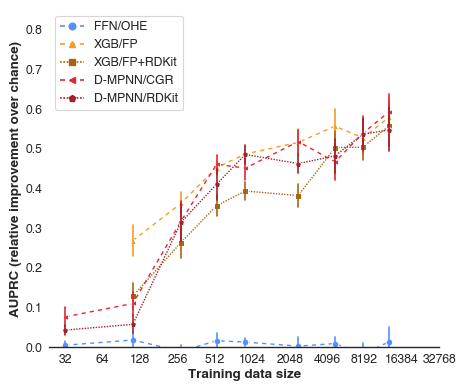

In [13]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
# choose the data to plot
experiment_ids = [
        [  # _10
            "JG1242",  # D-MPNN+CGR
            "JG1241",  # XGB+FP+RDKit
            "JG1240",  # FFN+OHE
            "JG1243",  # D-MPNN+CGR+RDKit
            "JG1285",  # XGB/FP
    ],
        [  # _15
            "JG1274",  # D-MPNN+CGR
            "JG1273",  # XGB+FP+RDKit
            "JG1272",  # FFN+OHE
            "JG1275",  # D-MPNN+CGR+RDKit
            "JG1284",  # XGB/FP
            
    ],
        [  # _20
            "JG1250",  # D-MPNN+CGR
            "JG1249",  # XGB+FP+RDKit
            "JG1248",  # FFN+OHE
            "JG1251",  # D-MPNN+CGR+RDKit
            "JG1283",  # XGB/FP
    ],
        [  # _25
            "JG1262",  # D-MPNN+CGR
            "JG1261",  # XGB+FP+RDKit
            "JG1260",  # FFN+OHE
            "JG1263",  # D-MPNN+CGR+RDKit
            "JG1282",  # XGB/FP
    ],
        [  # _30
            "JG1229",  # D-MPNN+CGR
            "JG1223",  # XGB+FP+RDKit
            "JG1217",  # FFN+OHE
            "JG1235",  # D-MPNN+CGR+RDKit
            "JG1281",  # XGB/FP
    ],
   #     [  # _34  # here we leave this one out as it is very close to _40 on the X-axis
   #         "JG1228",  # D-MPNN+CGR
   #         "JG1222",  # XGB+FP+RDKit
   #         "JG1216",  # FFN+OHE
   #         "JG1234",  # D-MPNN+CGR+RDKit
   #         "JG1280",  # XGB/FP
   # ],
        [  # _40
            "JG1227",  # D-MPNN+CGR
            "JG1221",  # XGB+FP+RDKit
            "JG1215",  # FFN+OHE
            "JG1233",  # D-MPNN+CGR+RDKit
            "JG1279",  # XGB/FP
    ],
        [  # _50
            "JG1226",  # D-MPNN+CGR
            "JG1220",  # XGB+FP+RDKit
            "JG1214",  # FFN+OHE
            "JG1232",  # D-MPNN+CGR+RDKit
            "JG1278",  # XGB/FP
    ],
        [  # _60
            "JG1225",  # D-MPNN+CGR
            "JG1219",  # XGB+FP+RDKit
            "JG1213",  # FFN+OHE
            "JG1231",  # D-MPNN+CGR+RDKit
            "JG1277",  # XGB/FP
    ],
        [  # _70
            "JG1224",  # D-MPNN+CGR
            "JG1218",  # XGB+FP+RDKit
            "JG1212",  # FFN+OHE
            "JG1230",  # D-MPNN+CGR+RDKit
            "JG1276",  # XGB/FP
    ],
]

sample_counts = {  # mean number of training samples for each split 
    "3D_10": 32,
    "3D_15": 112,
    "3D_20": 273,
    "3D_25": 529,
    "3D_30": 901,
    "3D_34": 1313,
    "3D_40": 2399,
    "3D_50": 4747,
    "3D_60": 7948,
    "3D_70": 12975,
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
chance_dict = {k: v for k, v in zip(sample_counts.keys(), chance_level)}
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0., 0.85))
ax.set_xticks(
    [32*2**n for n in range(11)], 
    [f"{32*2**n}" for n in range(11)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_3D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)